# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
from IPython.display import display

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('**** Raw Data ****')
print(azdias.shape)
display(azdias.head(5))
display(azdias.describe())

print('**** Feature Info ****')
print(feat_info.shape)
display(feat_info.head(5))
display(feat_info.describe())

**** Raw Data ****
(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


**** Feature Info ****
(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_PFLICHT,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
for index, row in feat_info.iterrows():
    nan_values = list(row.missing_or_unknown.replace('[','').replace(']','').split(','))
    azdias.loc[azdias[row.attribute].isin(nan_values), row.attribute]  = np.nan

azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nanCounts = azdias.isna().sum().sort_values(ascending=False)



In [6]:
total = len(azdias.index)
countDict={}
for i, v in nanCounts.iteritems():
    print(f'{i} % NaN: {(v/total) * 100} NaN count: {v}')
    key = v
    if v not in countDict.keys():
        countDict[key] = []
    countDict[key].append(i)

TITEL_KZ % NaN: 99.75763587258379 NaN count: 889061
AGER_TYP % NaN: 76.95543529607134 NaN count: 685843
KK_KUNDENTYP % NaN: 65.59674873011295 NaN count: 584612
KBA05_BAUMAX % NaN: 53.468668265222654 NaN count: 476524
GEBURTSJAHR % NaN: 44.02028228688507 NaN count: 392318
ALTER_HH % NaN: 34.81369940789097 NaN count: 310267
REGIOTYP % NaN: 17.73566825736826 NaN count: 158064
KKK % NaN: 17.73566825736826 NaN count: 158064
W_KEIT_KIND_HH % NaN: 16.60508448521747 NaN count: 147988
KBA05_ANTG4 % NaN: 14.959701353536328 NaN count: 133324
KBA05_GBZ % NaN: 14.959701353536328 NaN count: 133324
MOBI_REGIO % NaN: 14.959701353536328 NaN count: 133324
KBA05_ANTG1 % NaN: 14.959701353536328 NaN count: 133324
KBA05_ANTG2 % NaN: 14.959701353536328 NaN count: 133324
KBA05_ANTG3 % NaN: 14.959701353536328 NaN count: 133324
PLZ8_GBZ % NaN: 13.073637178657146 NaN count: 116515
PLZ8_HHZ % NaN: 13.073637178657146 NaN count: 116515
PLZ8_BAUMAX % NaN: 13.073637178657146 NaN count: 116515
PLZ8_ANTG4 % NaN: 13.073

In [7]:
# Investigate patterns in the amount of missing data in each column)
for key in countDict.keys():
    print(f'{key} - {countDict[key]}')

889061 - ['TITEL_KZ']
685843 - ['AGER_TYP']
584612 - ['KK_KUNDENTYP']
476524 - ['KBA05_BAUMAX']
392318 - ['GEBURTSJAHR']
310267 - ['ALTER_HH']
158064 - ['REGIOTYP', 'KKK']
147988 - ['W_KEIT_KIND_HH']
133324 - ['KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3']
116515 - ['PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_ANTG2']
111196 - ['SHOPPER_TYP', 'VERS_TYP', 'HEALTH_TYP']
108315 - ['NATIONALITAET_KZ']
108164 - ['PRAEGENDE_JUGENDJAHRE']
105800 - ['KBA13_ANZAHL_PKW']
99611 - ['ANZ_HAUSHALTE_AKTIV']
99352 - ['CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
97632 - ['LP_LEBENSPHASE_FEIN']
97375 - ['RELAT_AB', 'ARBEIT']
97274 - ['ORTSGR_KLS9']
97008 - ['ANZ_HH_TITEL']
94572 - ['LP_LEBENSPHASE_GROB']
93740 - ['INNENSTADT', 'EWDICHTE', 'BALLRAUM']
93155 - ['GEBAEUDETYP_RASTER']
93148 - ['MIN_GEBAEUDEJAHR', 'GEBAEUDETYP', 'WOHNLAGE', 'OST_WEST_KZ']
77792 - ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']
73969 - ['KONSU

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Remove these columns
# TITEL_KZ % NaN: 99.75763587258379 NaN count: 889061
# AGER_TYP % NaN: 76.95543529607134 NaN count: 685843
# KK_KUNDENTYP % NaN: 65.59674873011295 NaN count: 584612
# KBA05_BAUMAX % NaN: 53.468668265222654 NaN count: 476524
# GEBURTSJAHR % NaN: 44.02028228688507 NaN count: 392318
# ALTER_HH % NaN: 34.81369940789097 NaN count: 310267
columnsToDrop = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
azdiasDropped = azdias
noMissingDataFeatures=[]
someMissingDataFeatures=[]
for i, v in nanCounts.iteritems():
    perNaN = v/total
    if i in columnsToDrop:
        azdiasDropped = azdiasDropped.drop(i, axis=1)
    elif perNaN > 0:
        someMissingDataFeatures.append(i)
    else:
        noMissingDataFeatures.append(i)
print(azdiasDropped.shape)
azdiasDropped.head(5)    

(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


###### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

We removed 6 "bad" columns which had more than 34% of the values being NaN.  Some columns (i.e. TITEL_KZ) had as much as 99% of the data being bad, while over 60% of the columns had 8% or more of the data missing.

There was interesting clustering of values, where at least numerically, these values seemed to have missing values at the same time:
- ['REGIOTYP', 'KKK']
- ['KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3']
- ['PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_ANTG2']
- ['SHOPPER_TYP', 'VERS_TYP', 'HEALTH_TYP']
- ['CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015']
- ['INNENSTADT', 'EWDICHTE', 'BALLRAUM']
- ['MIN_GEBAEUDEJAHR', 'GEBAEUDETYP', 'WOHNLAGE', 'OST_WEST_KZ']
- ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']
- ['ANZ_PERSONEN', 'SOHO_KZ', 'ANZ_TITEL', 'WOHNDAUER_2008']
- ['CJT_GESAMTTYP', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
azdiasDroppedWithNanCount = azdiasDropped
azdiasDroppedWithNanCount['nanCount'] = azdiasDropped.isna().sum(axis=1)
azdiasDroppedWithNanCount.head(5)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nanCount
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [10]:
azdiasDroppedWithNanCount.groupby('nanCount').count()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
nanCount,,,,,,,,,,,,,,,,,,,,,
0,623209,623209,623209,623209,623209,623209,623209,623209,623209,623209,...,623209,623209,623209,623209,623209,623209,623209,623209,623209,623209
1,15738,15738,15738,15738,15738,15738,15738,15738,15738,15738,...,15738,15738,15738,15738,15738,15738,15738,15738,15738,15738
2,27926,27926,27926,27926,27926,27926,27926,27926,27926,27926,...,27926,27926,27926,27926,27926,27926,27926,27858,27926,27858
3,17629,17629,17629,17629,17629,17629,17629,17629,17629,17629,...,17629,17629,17629,17629,17629,17629,17629,14269,14271,14269
4,11190,12607,12607,12607,12607,12607,12607,12607,12607,12607,...,12607,12607,12607,12607,12607,12607,12607,12531,12535,12531
5,22401,22515,22515,22515,22515,22515,22515,22515,22515,22515,...,22515,22515,22515,22515,22515,22515,22515,22412,22414,22412
6,13319,13771,13771,13771,13771,13771,13771,13771,13771,13771,...,13771,13771,13771,13771,13771,13771,13771,13708,13710,13708
7,13228,13714,13714,13714,13714,13714,13714,13714,13714,13714,...,10877,10877,10877,10877,10877,10877,10877,13651,13652,13651
8,24578,24592,24592,24592,24592,24592,24592,24592,24592,24592,...,20205,20205,20205,20205,20205,20205,20205,24470,24474,24470


In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
maxNumMissingValues=49
rowsWithNoMissingData=azdiasDropped.dropna()
rowsWithMissingData=azdiasDropped[azdiasDropped.isna().any(1)]
totalRowsMissingData = len(rowsWithMissingData.index)
totalRowsWithNoMissingData = len(rowsWithNoMissingData.index)
print(f'Total number of rows without missing values: {totalRowsWithNoMissingData}')
print(f'Total number of rows missing any values: {totalRowsMissingData}')
print(f'Total rows from original: {total}')
print(f'Percentage of rows with missing values: {(totalRowsMissingData/total)*100}%')
print()
tuples = []
for x in range(2, maxNumMissingValues+1):
    totalRowsMissingX = len(azdiasDroppedWithNanCount.loc[azdiasDroppedWithNanCount["nanCount"] == x].index)
    tuples.append((x,totalRowsMissingX))




Total number of rows without missing values: 623209
Total number of rows missing any values: 268012
Total rows from original: 891221
Percentage of rows with missing values: 30.07245116531141%



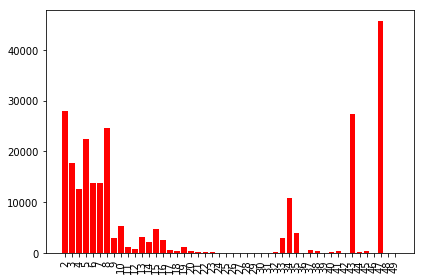

In [13]:
indices = np.arange(len(tuples))
numMissing = []
frequency = []
for i in range(len(tuples)):
  numMissing.append(tuples[i][0])
  frequency.append(tuples[i][1])

plt.bar(indices, frequency, color='r')
plt.xticks(indices, numMissing, rotation='vertical')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


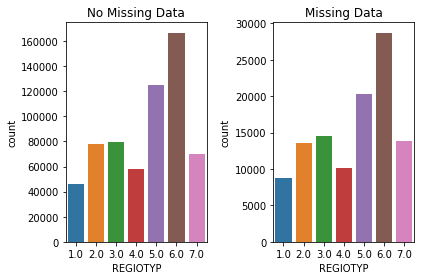

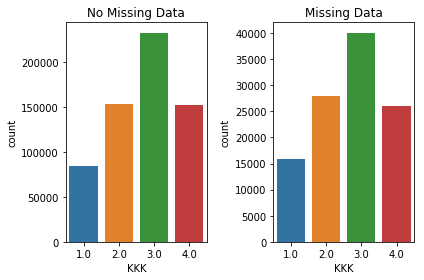

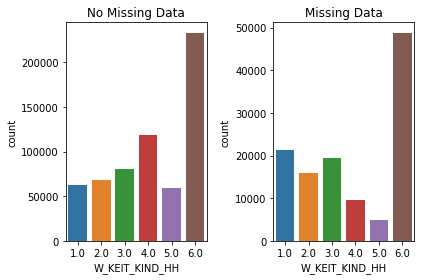

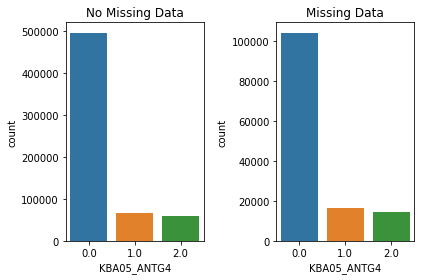

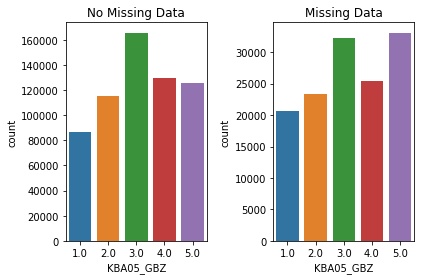

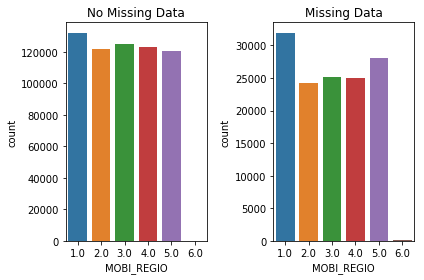

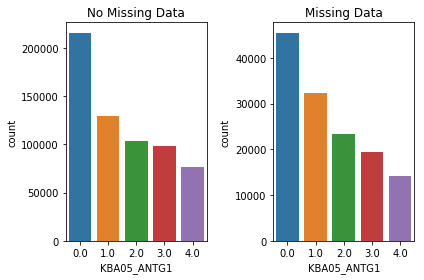

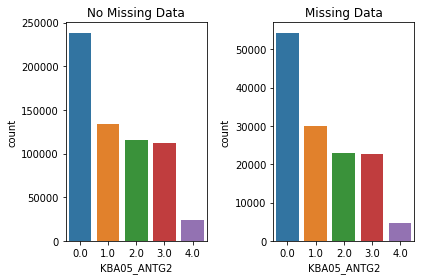

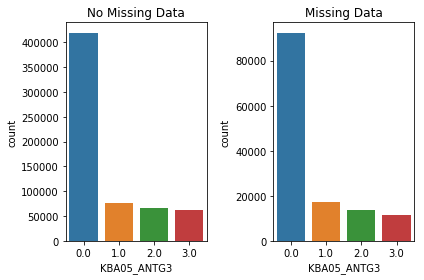

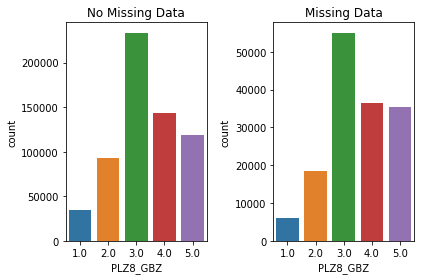

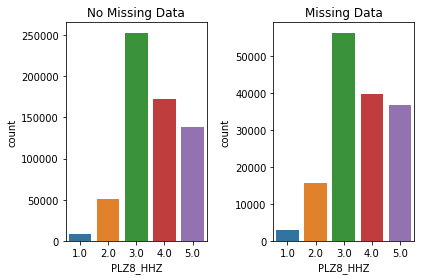

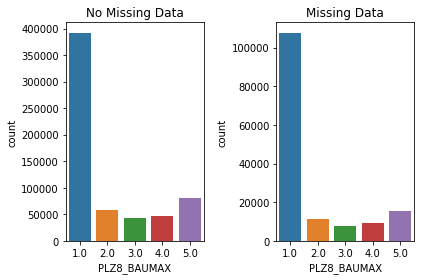

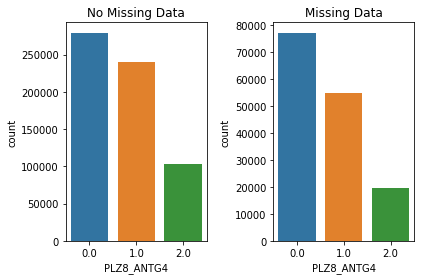

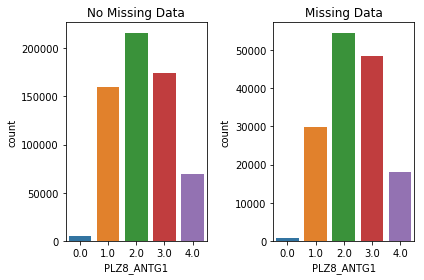

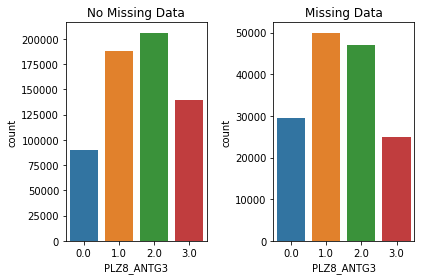

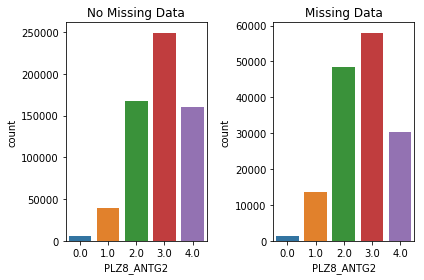

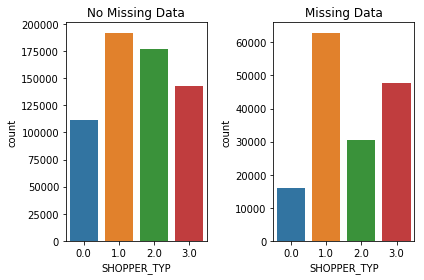

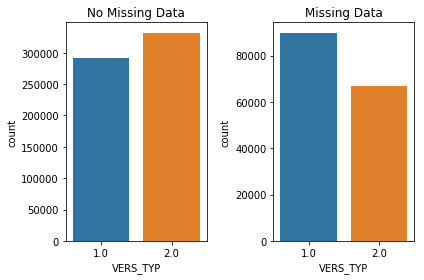

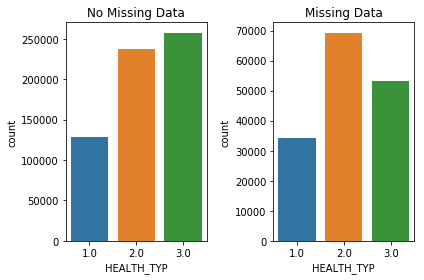

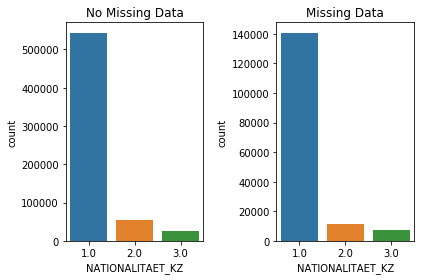

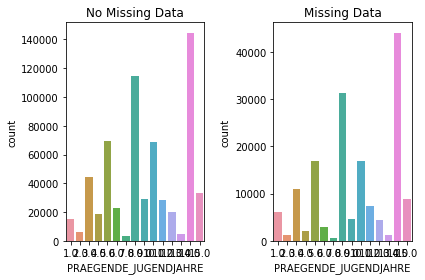

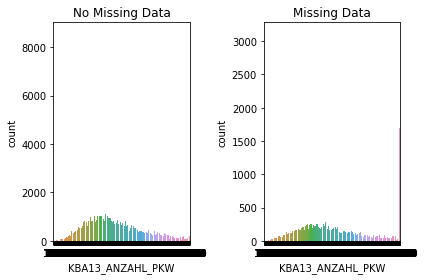

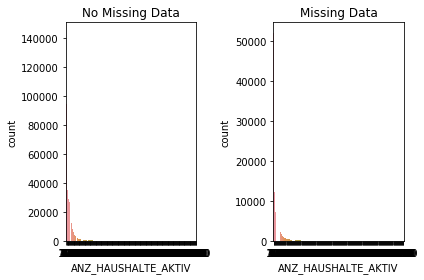

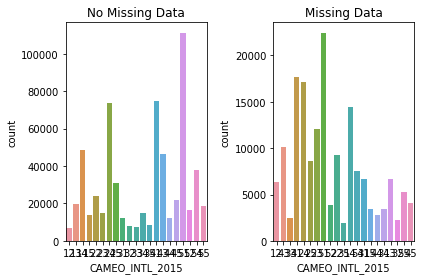

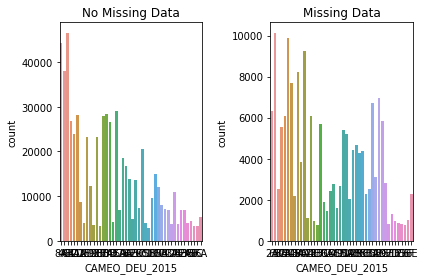

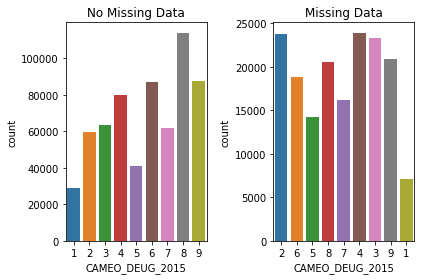

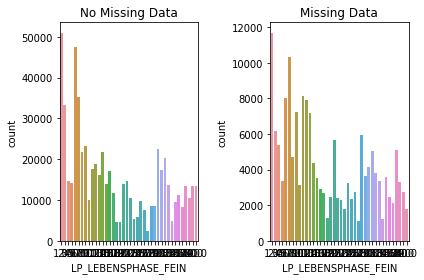

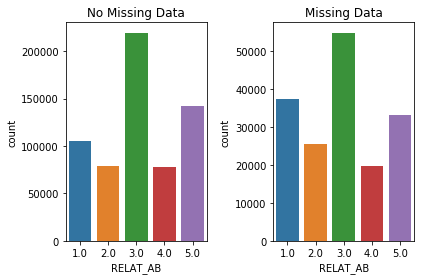

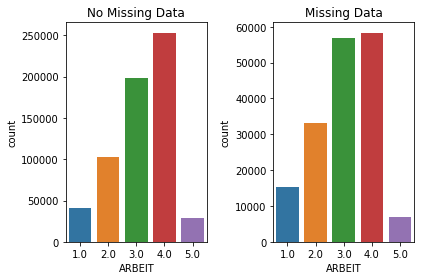

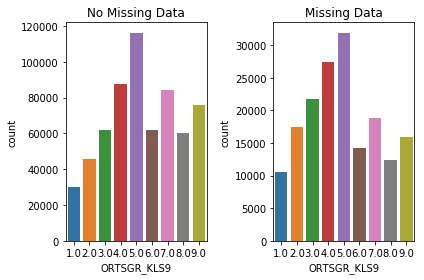

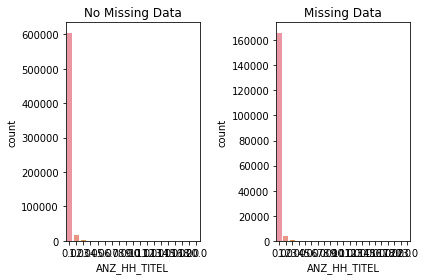

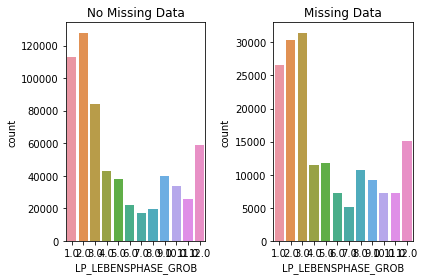

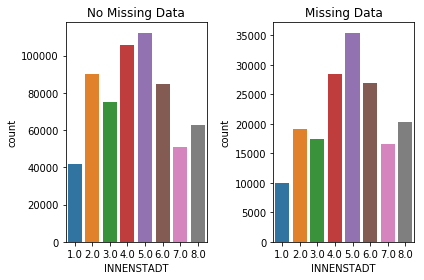

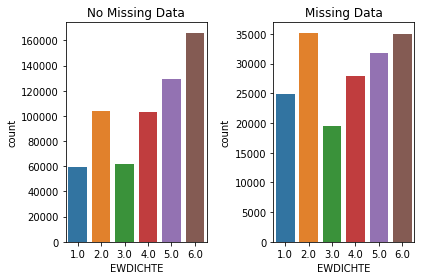

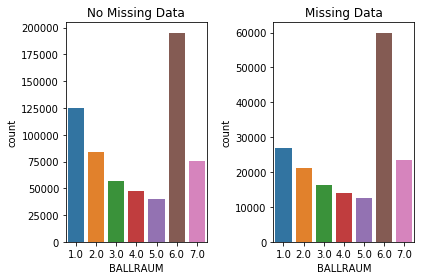

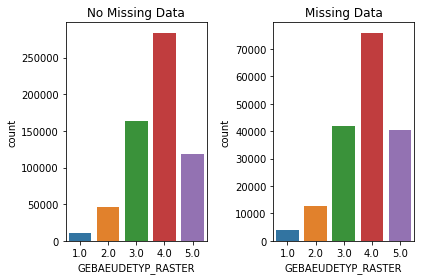

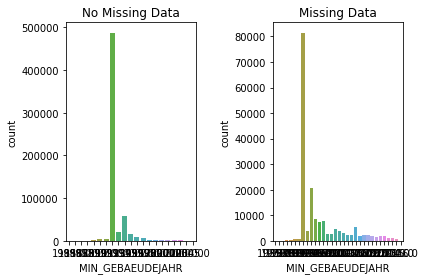

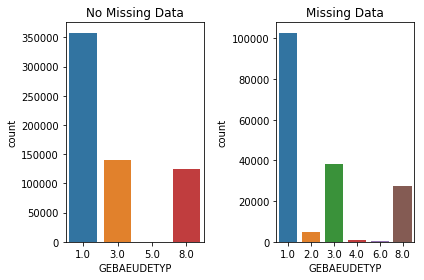

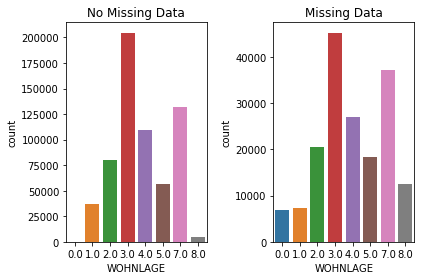

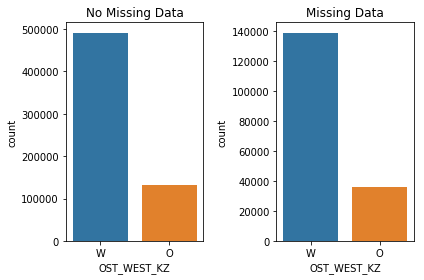

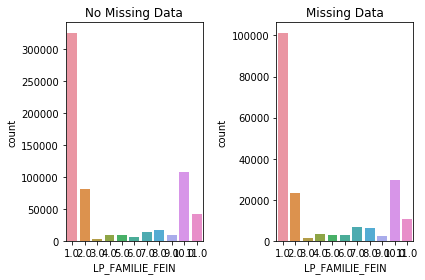

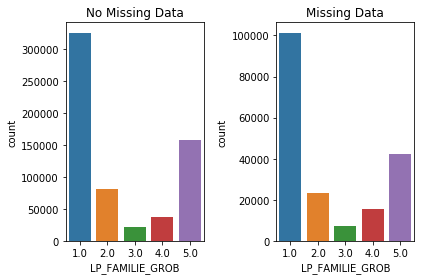

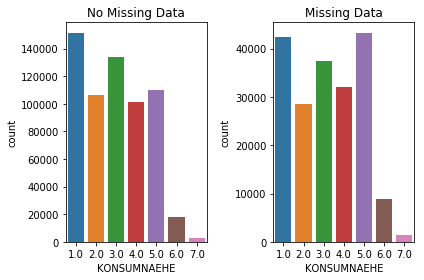

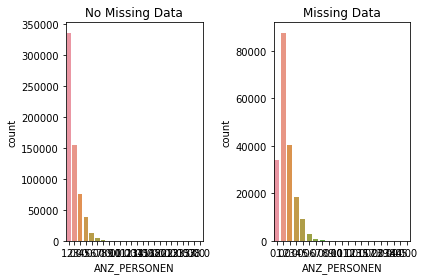

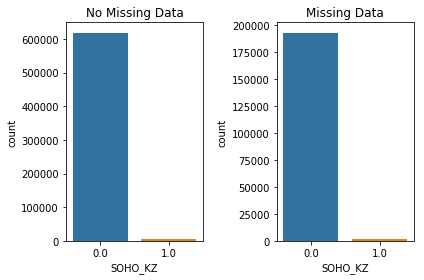

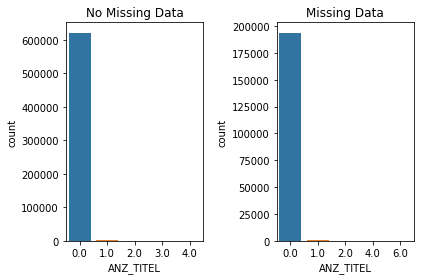

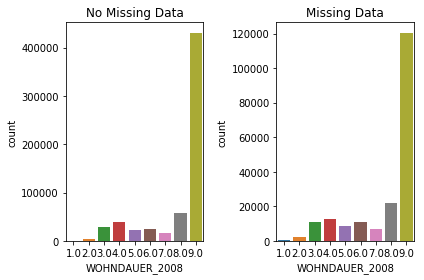

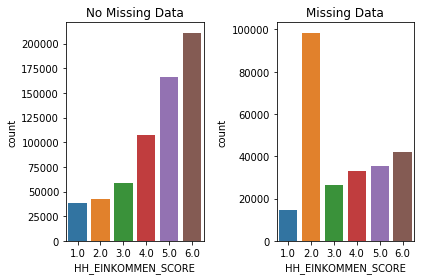

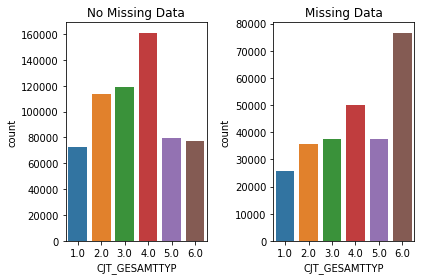

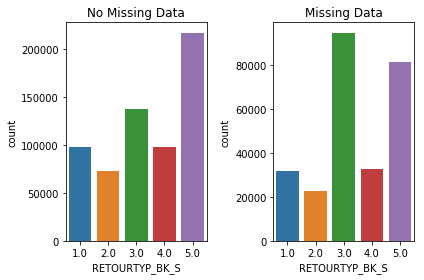

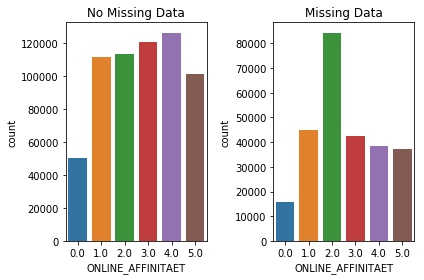

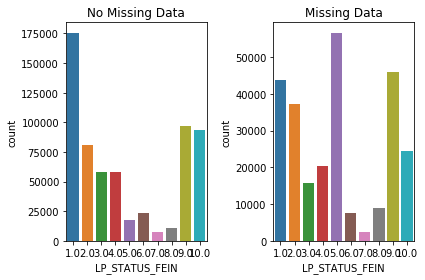

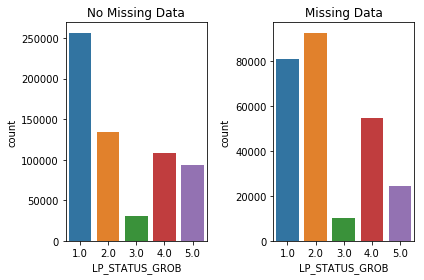

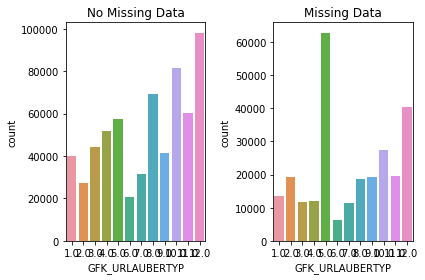

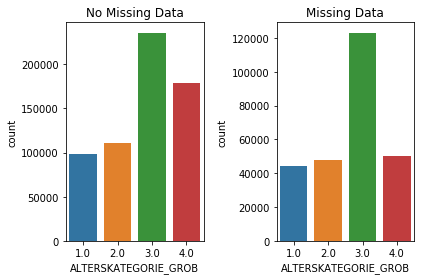

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for feature in someMissingDataFeatures:
    fig, ax =plt.subplots(1,2)
    sns.countplot(x=feature, data=rowsWithNoMissingData,ax=ax[0]).set_title('No Missing Data')
    sns.countplot(x=feature, data=rowsWithMissingData,ax=ax[1]).set_title('Missing Data')
    fig.tight_layout()
    fig.show()


In [15]:
print(f'Number of features that have missing data: {len(someMissingDataFeatures)}')
print(someMissingDataFeatures)

Number of features that have missing data: 55
['REGIOTYP', 'KKK', 'W_KEIT_KIND_HH', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'PLZ8_GBZ', 'PLZ8_HHZ', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_ANTG2', 'SHOPPER_TYP', 'VERS_TYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'LP_LEBENSPHASE_FEIN', 'RELAT_AB', 'ARBEIT', 'ORTSGR_KLS9', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_GROB', 'INNENSTADT', 'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'MIN_GEBAEUDEJAHR', 'GEBAEUDETYP', 'WOHNLAGE', 'OST_WEST_KZ', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'KONSUMNAEHE', 'ANZ_PERSONEN', 'SOHO_KZ', 'ANZ_TITEL', 'WOHNDAUER_2008', 'HH_EINKOMMEN_SCORE', 'CJT_GESAMTTYP', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'GFK_URLAUBERTYP', 'ALTERSKATEGORIE_GROB']


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

After removing the columns with over 16% of the data missing, we set forth to see if there were any differences in distribution between those rows with ANY missing data (222980 rows, or < 25% of the total), and those with no missing data.  

Analyzing the remaining 52 columns where some missing data was observed, here are a few of the differences in the missing values group:  
'SHOPPER_TYP' - Value 2.0 is observed significantly less in this population.   
'VERS_TYP'- Value 1.0 is observed significantly more in this popoulation.  
'CAMEO_INTL_2015' - There are several differences in population distribution.  
'CAMEO_DEU_2015' - There are several differences in population distribution.  
'CAMEO_DEUG_2015' - There are several differences in population distribution.  
'MIN_GEBAEUDEJAHR' - The most frequent value is distinctly differnt in this population.  
'CJT_GESAMTTYP' - Value 3.0 is observed significantly more in this population.   
'RETOURTYP_BK_S' - Value 3.0 is observed significantly less in this population.   
'ONLINE_AFFINITAET' - Value 1.0 is observed significantly more in this population.   
'LP_STATUS_FEIN' - Value 2.0 is observed significantly more in this population.   
'GFK_URLAUBERTYP' -  Values 5.0 and 8.0 are observed significantly less in this population.   


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


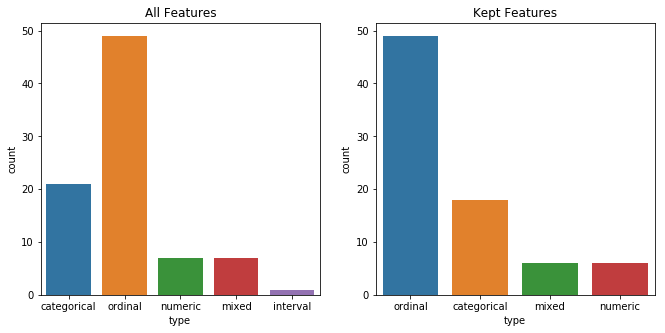

In [16]:
# How many features are there of each data type?
keptFeatures=someMissingDataFeatures + noMissingDataFeatures
reducedFeatures=feat_info[feat_info.attribute.isin(keptFeatures)]
fig, ax = plt.subplots(1,2,figsize=(11,5))
sns.countplot(x='type',data=feat_info,ax=ax[0]).set_title('All Features')
sns.countplot(x='type',data=reducedFeatures,ax=ax[1]).set_title('Kept Features')
fig.show()


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# From here forward we will use rowsWithNoMissingData as the dataset.  
# It has the 6 columns with more than 34% of missing data removed, and it has any rows with NaN values removed.
rowsWithNoMissingData.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nanCount
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0


In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# for feature in reducedFeatures["attribute"]:
featuresToDummy=[]
for feature in reducedFeatures[reducedFeatures.type=='categorical']["attribute"]:
    print(f'{feature}: {rowsWithNoMissingData[feature].unique()}')
    if len(rowsWithNoMissingData[feature].unique()) > 2:
        featuresToDummy.append(feature)

print(featuresToDummy)

ANREDE_KZ: [ 2.  1.]
CJT_GESAMTTYP: [ 5.  3.  2.  4.  1.  6.]
FINANZTYP: [ 1.  5.  2.  4.  6.  3.]
GFK_URLAUBERTYP: [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   6.   2.]
GREEN_AVANTGARDE: [ 0.  1.]
LP_FAMILIE_FEIN: [  5.   1.  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB: [ 3.  1.  5.  2.  4.]
LP_STATUS_FEIN: [  2.   3.   4.   1.  10.   9.   5.   6.   7.   8.]
LP_STATUS_GROB: [ 1.  2.  5.  4.  3.]
NATIONALITAET_KZ: [ 1.  2.  3.]
SHOPPER_TYP: [ 3.  2.  0.  1.]
SOHO_KZ: [ 1.  0.]
VERS_TYP: [ 2.  1.]
ZABEOTYP: [ 5.  4.  1.  6.  3.  2.]
GEBAEUDETYP: [ 8.  1.  3.  5.]
OST_WEST_KZ: ['W' 'O']
CAMEO_DEUG_2015: ['8' '4' '6' '2' '1' '9' '5' '7' '3']
CAMEO_DEU_2015: ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '9B' '1B' '8B' '7A'
 '3D' '4E' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '5C' '9C' '7D' '5E' '1D' '8D'
 '6C' '5B' '7C' '4D' '3A' '2B' '7E' '4B' '2A' '3B' '6F' '5F' '1C' '6A']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 

In [19]:
rowsWithNoMissingData.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nanCount
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0


In [20]:
# DROPING CAMEO_DEU_2015 Given it has so many values
rowsWithNoMissingData_encoded = rowsWithNoMissingData.drop('CAMEO_DEU_2015', axis=1)
featuresToDummyLessCameo2015 = featuresToDummy.copy()
featuresToDummyLessCameo2015.remove('CAMEO_DEU_2015')
rowsWithNoMissingData_encoded.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nanCount
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0


In [21]:
# Re-encode OST_WEST_KZ - W == 1, O == 0
rowsWithNoMissingData_encoded.loc[rowsWithNoMissingData_encoded['OST_WEST_KZ'] == 'W', "OST_WEST_KZ"] = 1
rowsWithNoMissingData_encoded.loc[rowsWithNoMissingData_encoded['OST_WEST_KZ'] == 'O', "OST_WEST_KZ"] = 0
rowsWithNoMissingData_encoded.head(5)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nanCount
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
rowsWithNoMissingData_encoded = pd.get_dummies(rowsWithNoMissingData_encoded, prefix=featuresToDummyLessCameo2015,columns=featuresToDummyLessCameo2015)
rowsWithNoMissingData_encoded.head(5)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1,0,0,0,0,0,0,0,1,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,1,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,0,0,0,0,1,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
len(featuresToDummy)

13

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

After removing columns with more than 16% bad values, there were 18 categorical features remaining. With those we did the following:
- those with only 2 unique numerical values we kept as is.
- we deleted CAMEO_DEU_2015 because it had so many values.
- manually recoded OST_WEST_KZ's values to numbers
- created dummy categories for the remaining 12 features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
for feature in reducedFeatures[reducedFeatures.type=='mixed']["attribute"]:
    print(f'{feature}: {rowsWithNoMissingData_encoded[feature].unique()}')

LP_LEBENSPHASE_FEIN: [ 21.   3.  32.   8.   2.   5.  10.   4.   6.  20.   1.  25.  18.  31.  38.
  30.   7.  22.  14.  35.  29.  24.  37.  12.  39.  36.  13.   9.  34.  26.
  33.  15.  11.  40.  16.  19.  23.  27.  28.  17.]
LP_LEBENSPHASE_GROB: [  6.   1.  10.   2.   3.   5.   7.  12.   9.   4.  11.   8.]
PRAEGENDE_JUGENDJAHRE: [ 14.  15.   8.   3.  10.  11.   9.   5.   4.   2.   6.   1.  12.  13.   7.]
WOHNLAGE: [ 4.  2.  3.  7.  5.  1.  8.  0.]
CAMEO_INTL_2015: ['51' '24' '43' '54' '22' '14' '13' '15' '34' '55' '41' '25' '31' '52' '45'
 '35' '33' '44' '32' '23' '12']
PLZ8_BAUMAX: [ 1.  2.  4.  5.  3.]


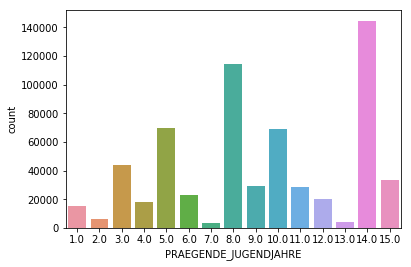

In [26]:
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)
sns.countplot(x='PRAEGENDE_JUGENDJAHRE', data=rowsWithNoMissingData_encoded)


In [27]:
 
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
rowsWithNoMissingData_encoded_pj = rowsWithNoMissingData_encoded
#Mainstream = 1
#Avantegard = 0

def encodeDecade(x):
    x = int(x)
    d = None
    if x in [1,2]:
        d = 4
    if x in [3,4]:
        d = 5
    if x in [5,6,7]:
        d = 6
    if x in [8,9]:
        d = 7
    if x in [10,11,12,13]:
        d = 8
    if x in [14,15]:
        d = 9
    return int(d)
    
    
rowsWithNoMissingData_encoded_pj['AVANT_O_MAIN'] = [1 if x in [1, 3, 5, 8, 10, 12, 14] else 0 for x in rowsWithNoMissingData_encoded_pj['PRAEGENDE_JUGENDJAHRE']]
rowsWithNoMissingData_encoded_pj['DECADE'] = [encodeDecade(x) for x in rowsWithNoMissingData_encoded_pj['PRAEGENDE_JUGENDJAHRE']]
rowsWithNoMissingData_encoded_pj=rowsWithNoMissingData_encoded_pj.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
rowsWithNoMissingData_encoded_pj.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANT_O_MAIN,DECADE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,0,0,1,0,1,9
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,1,0,0,0,0,0,0,9
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,1,0,0,0,1,7
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,0,0,1,0,1,5
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0,0,1,0,0,0,0,0,1,8


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


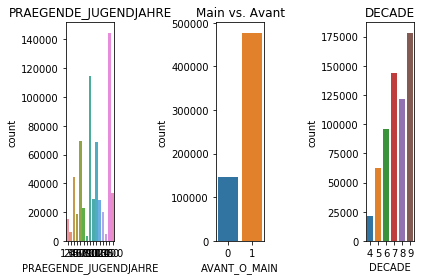

In [28]:
fig, ax =plt.subplots(1,3)
sns.countplot(x='PRAEGENDE_JUGENDJAHRE', data=rowsWithNoMissingData_encoded,ax=ax[0]).set_title('PRAEGENDE_JUGENDJAHRE')
sns.countplot(x='AVANT_O_MAIN', data=rowsWithNoMissingData_encoded_pj,ax=ax[1]).set_title('Main vs. Avant')
sns.countplot(x='DECADE', data=rowsWithNoMissingData_encoded_pj,ax=ax[2]).set_title('DECADE')
fig.tight_layout()
fig.show()

In [29]:
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

#wealth and life stage. 
#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
# (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
rowsWithNoMissingData_encoded_cameo = rowsWithNoMissingData_encoded_pj
# 1 - Wealthy
# 2 - Prosperous
# 3 - Comfortable
# 4 - Less Affluent
# 5 - Poor
rowsWithNoMissingData_encoded_cameo['CAMEO_WEALTH'] = [int(x[:1]) for x in rowsWithNoMissingData_encoded_cameo['CAMEO_INTL_2015']]
# 1 - Pre-Family
# 2 - Young w/ Child
# 3 - School Age Families
# 4 - Older Families
# 5 - Elders
rowsWithNoMissingData_encoded_cameo['CAMEO_LIFESTAGE'] = [int(x[1:2]) for x in rowsWithNoMissingData_encoded_cameo['CAMEO_INTL_2015']]
rowsWithNoMissingData_encoded_cameo = rowsWithNoMissingData_encoded_cameo.drop('CAMEO_INTL_2015', axis=1)
rowsWithNoMissingData_encoded_cameo.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANT_O_MAIN,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,1,0,1,9,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1,0,0,0,0,0,0,9,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,1,0,0,0,1,7,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,1,0,1,5,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,1,0,0,0,0,0,1,8,2,2


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


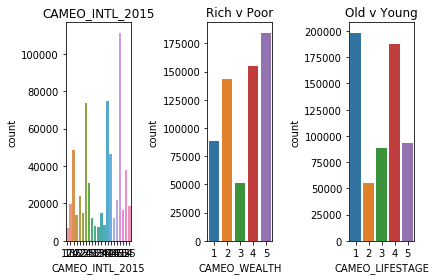

In [30]:
# Analyze
fig, ax =plt.subplots(1,3)
sns.countplot(x='CAMEO_INTL_2015', data=rowsWithNoMissingData_encoded,ax=ax[0]).set_title('CAMEO_INTL_2015')
sns.countplot(x='CAMEO_WEALTH', data=rowsWithNoMissingData_encoded_cameo,ax=ax[1]).set_title('Rich v Poor')
sns.countplot(x='CAMEO_LIFESTAGE', data=rowsWithNoMissingData_encoded_cameo,ax=ax[2]).set_title('Old v Young')
fig.tight_layout()
fig.show()

In [31]:
# Delete other mixed features
cleanedDF = rowsWithNoMissingData_encoded_cameo
cleanedDF = cleanedDF.drop('LP_LEBENSPHASE_FEIN', axis=1)
cleanedDF = cleanedDF.drop('LP_LEBENSPHASE_GROB', axis=1)
cleanedDF = cleanedDF.drop('WOHNLAGE', axis=1)
cleanedDF = cleanedDF.drop('PLZ8_BAUMAX', axis=1)
cleanedDF.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANT_O_MAIN,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,0,0,0,1,0,1,9,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1,0,0,0,0,0,0,9,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,1,0,0,0,1,7,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,0,1,0,1,5,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,1,0,0,0,0,0,1,8,2,2


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)  

There were 6 mixed type features remaining after the initial cleanup.

4 of them I dropped in the interest of time.
The other two I recoded their multi-meaning values into separate single meaning values per the instructions.  `CAMEO_INTL_2015` has a somewhat even distribution in the two new data fields for wealth and lifestage, where as
`PRAEGENDE_JUGENDJAHRE` did not separate so nicely.  The usage of Mainstream vs. Avantegard made sense as one category based upon the data, but the distribution was is quite skewed.  The division by decade is also skewed, with more samples from more recent decades than older.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

cleanedDF.shape

(623209, 146)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
from IPython.display import display

def encodeDecade(x):
    x = int(x)
    d = None
    if x in [1,2]:
        d = 4
    if x in [3,4]:
        d = 5
    if x in [5,6,7]:
        d = 6
    if x in [8,9]:
        d = 7
    if x in [10,11,12,13]:
        d = 8
    if x in [14,15]:
        d = 9
    return int(d)

def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame - df, 
            Feature Info - feat_info, 
            Threshold for percent (as decimal) missing values to drop a column - per_missing_threshold
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Identify missing or unknown data values and convert them to NaNs.
    for index, row in feat_info.iterrows():
        nan_values = list(row.missing_or_unknown.replace('[','').replace(']','').split(','))
        df.loc[df[row.attribute].isin(nan_values), row.attribute]  = np.nan
    # Perform an assessment of how much missing data there is in each column of the
    # dataset.
    nanCounts = df.isna().sum().sort_values(ascending=False)
    total = len(df.index)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, row in feat_info.iterrows():
        nan_values = list(row.missing_or_unknown.replace('[','').replace(']','').split(','))
        df.loc[df[row.attribute].isin(nan_values), row.attribute]  = np.nan
    
    # remove selected columns
    dfDropped = df
    noMissingDataFeatures=[]
    someMissingDataFeatures=[]
    columnsToDrop = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    for i, v in nanCounts.iteritems():
        perNaN = v/total
        if i in columnsToDrop:
            dfDropped = dfDropped.drop(i, axis=1)
        elif perNaN > 0:
            someMissingDataFeatures.append(i)
        else:
            noMissingDataFeatures.append(i)
    
    # remove selected rows - rows with any missing data
    dfNoMissingData=dfDropped.dropna()
    # select, re-encode, and engineer column values.
    keptFeatures=someMissingDataFeatures + noMissingDataFeatures
    reducedFeatures=feat_info[feat_info.attribute.isin(keptFeatures)]
    featuresToDummy=[]
    for feature in reducedFeatures[reducedFeatures.type=='categorical']["attribute"]:
        if len(dfNoMissingData[feature].unique()) > 2:
            featuresToDummy.append(feature)
    # DROPING CAMEO_DEU_2015 Given it has so many values
    dfNoMissingData_encoded = dfNoMissingData.drop('CAMEO_DEU_2015', axis=1)
    featuresToDummyLessCameo2015 = featuresToDummy.copy()
    featuresToDummyLessCameo2015.remove('CAMEO_DEU_2015')
    # Re-encode OST_WEST_KZ - W == 1, O == 0
    dfNoMissingData_encoded.loc[dfNoMissingData_encoded['OST_WEST_KZ'] == 'W', "OST_WEST_KZ"] = 1
    dfNoMissingData_encoded.loc[dfNoMissingData_encoded['OST_WEST_KZ'] == 'O', "OST_WEST_KZ"] = 0
    # Re-encode categorical variable(s) to be kept in the analysis.
    dfNoMissingData_encoded = pd.get_dummies(dfNoMissingData_encoded, prefix=featuresToDummyLessCameo2015,columns=featuresToDummyLessCameo2015)
    # Re-engineer PRAEGENDE_JUGENDJAHRE
    dfNoMissingData_encoded_pj = dfNoMissingData_encoded
    #Mainstream = 1
    #Avantegard = 0
    dfNoMissingData_encoded_pj['AVANT_O_MAIN'] = [1 if x in [1, 3, 5, 8, 10, 12, 14] else 0 for x in dfNoMissingData_encoded_pj['PRAEGENDE_JUGENDJAHRE']]
    dfNoMissingData_encoded_pj['DECADE'] = [encodeDecade(x) for x in dfNoMissingData_encoded_pj['PRAEGENDE_JUGENDJAHRE']]
    dfNoMissingData_encoded_pj = dfNoMissingData_encoded_pj.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    dfNoMissingData_encoded_cameo = dfNoMissingData_encoded_pj
    # 1 - Wealthy
    # 2 - Prosperous
    # 3 - Comfortable
    # 4 - Less Affluent
    # 5 - Poor
    dfNoMissingData_encoded_cameo['CAMEO_WEALTH'] = [int(x[:1]) for x in dfNoMissingData_encoded_cameo['CAMEO_INTL_2015']]
    # 1 - Pre-Family
    # 2 - Young w/ Child
    # 3 - School Age Families
    # 4 - Older Families
    # 5 - Elders
    dfNoMissingData_encoded_cameo['CAMEO_LIFESTAGE'] = [int(x[1:2]) for x in dfNoMissingData_encoded_cameo['CAMEO_INTL_2015']]
    dfNoMissingData_encoded_cameo=dfNoMissingData_encoded_cameo.drop('CAMEO_INTL_2015', axis=1) 
    cleanDF = dfNoMissingData_encoded_cameo
    cleanDF = cleanDF.drop('LP_LEBENSPHASE_FEIN', axis=1)
    cleanDF = cleanDF.drop('LP_LEBENSPHASE_GROB', axis=1)
    cleanDF = cleanDF.drop('WOHNLAGE', axis=1)
    cleanDF = cleanDF.drop('PLZ8_BAUMAX', axis=1)

    # Return the cleaned dataframe.
    return cleanDF
    

In [35]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')
# **************** CAN START FROM HERE after loading data **********************
resultDF = clean_data(azdias, feat_info)
print(resultDF.shape)

(623209, 145)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [65]:
# Apply feature scaling to the general population demographics data.
from sklearn import preprocessing as p
#Scale
scaler = p.StandardScaler() 
cleanedScaledRaw = scaler.fit_transform(resultDF)
cleanedScaledDF = pd.DataFrame(cleanedScaledRaw)
# Apply Column Names
cleanedScaledDF.columns = resultDF.columns
cleanedScaledDF.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,AVANT_O_MAIN,DECADE,CAMEO_WEALTH,CAMEO_LIFESTAGE
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.383817,-0.265613,-0.403042,-0.33159,2.114432,-0.403596,0.553670,1.164454,1.147882,-1.251108
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,2.605411,-0.265613,-0.403042,-0.33159,-0.472940,-0.403596,-1.806129,1.164454,-0.909997,0.749822
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,-0.383817,-0.265613,2.481129,-0.33159,-0.472940,-0.403596,0.553670,-0.213400,0.461922,0.082845
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,-0.383817,-0.265613,-0.403042,-0.33159,2.114432,-0.403596,0.553670,-1.591253,1.147882,0.749822
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,2.605411,-0.265613,-0.403042,-0.33159,-0.472940,-0.403596,0.553670,0.475527,-0.909997,-0.584131


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)  

Given the instructions, feature scaling was fairly simple.  I had already eliminated columns with an abundance of NaN values, and rows with any NaN values.  At that point, all I had to do was apply the Standard Scaler as advised.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(len(resultDF.columns))
X_pca = pca.fit_transform(cleanedScaledRaw)


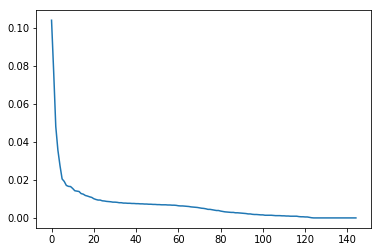

In [38]:
# Investigate the variance accounted for by each principal component.
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
plt.plot(variance_ratios)

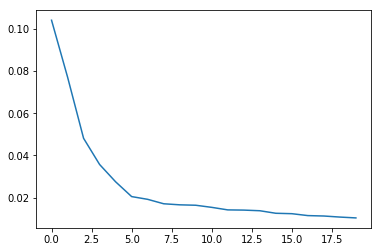

In [62]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_reduced = PCA(20)
X_pca_reduced = pca_reduced.fit_transform(cleanedScaledRaw)
ratios_reduced = pca_reduced.explained_variance_ratio_.reshape(len(pca_reduced.components_), 1)
variance_ratios_reduced = pd.DataFrame(np.round(ratios_reduced, 4), columns = ['Explained Variance'])
plt.plot(variance_ratios_reduced)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)   

There seemed to be a leveling off at about 20, and then again at 60.  60 seemed like too many components, so going with 20 for now.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_analysis(pca, df, pc_num):
   df = pd.DataFrame({'feature':df.columns,'weight':pca.components_[pc_num]})
   print(df.sort_values(by=['weight'],ascending=False))
pca_analysis(pca_reduced, resultDF, 1)


                   feature    weight
0     ALTERSKATEGORIE_GROB  0.221573
4         FINANZ_VORSORGER  0.200662
124           ZABEOTYP_3.0  0.198278
17               SEMIO_ERL  0.180119
10          RETOURTYP_BK_S  0.155625
16              SEMIO_LUST  0.151985
30          W_KEIT_KIND_HH  0.132093
100     LP_STATUS_FEIN_1.0  0.115480
7         FINANZ_HAUSBAUER  0.106255
61       CJT_GESAMTTYP_2.0  0.097503
53              PLZ8_ANTG3  0.093145
70           FINANZTYP_5.0  0.092193
54              PLZ8_ANTG4  0.088785
20              SEMIO_KRIT  0.086359
43                EWDICHTE  0.085308
58             ORTSGR_KLS9  0.085055
143           CAMEO_WEALTH  0.080154
84     LP_FAMILIE_FEIN_1.0  0.078000
95     LP_FAMILIE_GROB_1.0  0.078000
67           FINANZTYP_2.0  0.072944
121        SHOPPER_TYP_3.0  0.070872
40             KBA05_ANTG4  0.067529
22              SEMIO_KAEM  0.066930
60       CJT_GESAMTTYP_1.0  0.066287
57                  ARBEIT  0.065435
71           FINANZTYP_6.0  0.062490
5

In [41]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_analysis(pca_reduced, resultDF, 2)

                   feature    weight
15              SEMIO_VERT  0.321383
12               SEMIO_FAM  0.259284
11               SEMIO_SOZ  0.256413
18              SEMIO_KULT  0.244808
70           FINANZTYP_5.0  0.139130
2        FINANZ_MINIMALIST  0.127928
118        SHOPPER_TYP_0.0  0.126846
13               SEMIO_REL  0.117160
122           ZABEOTYP_1.0  0.115506
10          RETOURTYP_BK_S  0.085572
14               SEMIO_MAT  0.080052
30          W_KEIT_KIND_HH  0.075342
8         GREEN_AVANTGARDE  0.073647
43                EWDICHTE  0.066938
58             ORTSGR_KLS9  0.065952
127           ZABEOTYP_6.0  0.052536
54              PLZ8_ANTG4  0.051129
53              PLZ8_ANTG3  0.050769
114     LP_STATUS_GROB_5.0  0.050050
109    LP_STATUS_FEIN_10.0  0.050050
4         FINANZ_VORSORGER  0.049712
100     LP_STATUS_FEIN_1.0  0.046307
102     LP_STATUS_FEIN_3.0  0.045871
119        SHOPPER_TYP_1.0  0.044747
52              PLZ8_ANTG2  0.036821
59                RELAT_AB  0.035568
1

In [42]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_analysis(pca_reduced, resultDF, 3)


                   feature    weight
8         GREEN_AVANTGARDE  0.284391
114     LP_STATUS_GROB_5.0  0.233231
109    LP_STATUS_FEIN_10.0  0.233231
43                EWDICHTE  0.213844
58             ORTSGR_KLS9  0.209664
27            ANZ_PERSONEN  0.157883
99     LP_FAMILIE_GROB_5.0  0.133902
48       ONLINE_AFFINITAET  0.129608
21               SEMIO_DOM  0.125328
22              SEMIO_KAEM  0.117754
123           ZABEOTYP_2.0  0.111087
53              PLZ8_ANTG3  0.109590
54              PLZ8_ANTG4  0.103151
132      CAMEO_DEUG_2015_1  0.093592
93    LP_FAMILIE_FEIN_10.0  0.093385
59                RELAT_AB  0.090601
1                ANREDE_KZ  0.087647
52              PLZ8_ANTG2  0.086584
94    LP_FAMILIE_FEIN_11.0  0.081671
70           FINANZTYP_5.0  0.081207
122           ZABEOTYP_1.0  0.072673
55                PLZ8_HHZ  0.071594
112     LP_STATUS_GROB_3.0  0.069730
121        SHOPPER_TYP_3.0  0.067905
57                  ARBEIT  0.067095
133      CAMEO_DEUG_2015_2  0.058358
9

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

```                              
PC-1               feature    weight   
0     ALTERSKATEGORIE_GROB  0.225349 - Estimated Age
4         FINANZ_VORSORGER  0.203772 - Financial Typology - be prepared
121           ZABEOTYP_3.0  0.198952 - Energy consumption typology - fair supplied
17               SEMIO_ERL  0.184728 - Personality typology - event-oriented
10          RETOURTYP_BK_S  0.156798 - Return type (how much they return items)
...
24             SEMIO_TRADV -0.203025 - Personality typology - tradional-minded
6    FINANZ_UNAUFFAELLIGER -0.206060 - Financial Typology - inconspicuous
3            FINANZ_SPARER -0.209951 - Financial Typology - money-saver
13               SEMIO_REL -0.216833 - Personality typology - religious
139                 DECADE -0.226801 - Decade of person's Youth
```
Evaluation:  This seems reasonable.  Different age related fields are strongest and at opposite ends of the spectrum.  Constrasting financial and personality typologies are represented at each end as well.
```
PC-2             feature    weight
15              SEMIO_VERT  0.322533 - dreamful
11               SEMIO_SOZ  0.257836 - socially-minded
12               SEMIO_FAM  0.257317 - family-minded
18              SEMIO_KULT  0.245869 - cultural-minded
67           FINANZTYP_5.0  0.138255 - investor
...
17               SEMIO_ERL -0.196572 - event-oriented
20              SEMIO_KRIT -0.260154 - critical-minded
21               SEMIO_DOM -0.282770 - dominant-minded
22              SEMIO_KAEM -0.313827 - combative attitude
1                ANREDE_KZ -0.345940 - gender
```
Evaluation: Again, this seems resonable.  Largely a personality PC, with like peronsality types clustering and typically mutually exclusive types at opposite ends of the spectrum.
```
PC-3             feature    weight
8         GREEN_AVANTGARDE  0.295829 - Membership in environmental sustainability as part of youth
106    LP_STATUS_FEIN_10.0  0.253373 - Social Status (fine) - Top Earners
111     LP_STATUS_GROB_5.0  0.253373 - Social Status (rough) - Top Earners
42                EWDICHTE  0.215322 - Household density 
55             ORTSGR_KLS9  0.213218 - Size of community
...
105     LP_STATUS_FEIN_9.0 -0.183038 - Social Status (fine) - Houseowners
92     LP_FAMILIE_GROB_1.0 -0.186276 - Family type (rough) - single
81     LP_FAMILIE_FEIN_1.0 -0.186276 - Family type (fine) - single
110     LP_STATUS_GROB_4.0 -0.194981 - Social Status (rough) - Houseowners
138           AVANT_O_MAIN -0.295829 - Aventgarde or Mainstream from PRAEGENDE_JUGENDJAHRE
```
Evalution: Again, reasonable clustering of data.  In multiple cases different features that meant the same thing were grouped together, and two different representations of avantgarde were polar opposites on the scale.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
from sklearn.cluster import KMeans

In [46]:
# Look for the elbow in the first 10
kScoreTuples = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(X_pca_reduced)
    kScoreTuples.append((i, kmeans.score(X_pca_reduced)))

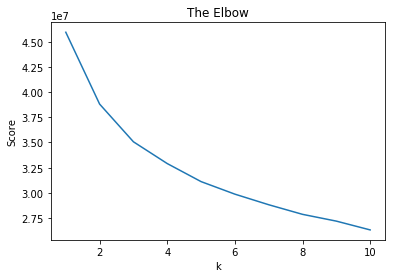

In [50]:
# Plot the elbow
plt.plot([x[0] for x in kScoreTuples],[-x[1] for x in kScoreTuples])
plt.xlabel('k')
plt.ylabel('Score')
plt.title('The Elbow')
plt.show()

In [51]:
# Try 15 and 20..
for i in [15,20]:
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(X_pca_reduced)
    kScoreTuples.append((i, kmeans.score(X_pca_reduced)))

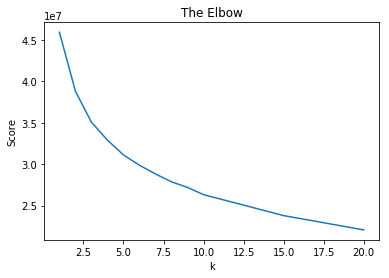

In [52]:
# Plot the elbow...again
plt.plot([x[0] for x in kScoreTuples],[-x[1] for x in kScoreTuples])
plt.xlabel('k')
plt.ylabel('Score')
plt.title('The Elbow')
plt.show()

In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# While there is no true elbow, 10 seems like a resonable k
kmeans = KMeans(n_clusters=10, random_state=10)
kmeans.fit(X_pca_reduced)
demoLabels = kmeans.predict(X_pca_reduced)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I re-did this step and maped the inverse of the score, which shows the diminshing incremental gains from an increasing k.  While there there is no true 'elbow' the increase seems to switch from exponential to linear near 10.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cleanedCustomer = clean_data(customers, feat_info)
print(cleanedCustomer.shape)
print(set(resultDF.columns) - set(cleanedCustomer.columns))

(115643, 144)
{'GEBAEUDETYP_5.0'}


In [66]:
# The customer segment did not have any "5's" for GEBAEUDETYP.  Adding that so the shapes match
cleanedCustomer['GEBAEUDETYP_5.0'] = 0
scaledCustomer = scaler.transform(cleanedCustomer)

In [67]:
X_pca_customer = pca_reduced.transform(scaledCustomer)
customerLabels = kmeans.predict(X_pca_customer)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [68]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sns
centers = kmeans.cluster_centers_
demoByCluster = []
customerByCluster = []
difference = []
for i in range(10):
    demoByCluster.append(len(demoLabels[np.where(demoLabels==i)])/len(demoLabels))
    customerByCluster.append(len(customerLabels[np.where(customerLabels==i)])/len(customerLabels)) 
    difference.append(demoByCluster[i] - customerByCluster[i])
df = pd.DataFrame({'Cluster': range(1,11),'General': demoByCluster, 'Customer': customerByCluster, 'Difference': difference})
df.head(30)

,Cluster,General,Customer,Difference
0,1,0.088152,0.132753,-0.044602
1,2,0.089187,0.011397,0.077790
2,3,0.130675,0.453447,-0.322772
3,4,0.130420,0.054236,0.076184
4,5,0.044556,0.049869,-0.005313
5,6,0.109278,0.007618,0.101660
6,7,0.072377,0.013801,0.058576
7,8,0.084214,0.007056,0.077158
8,9,0.136299,0.156577,-0.020277
9,10,0.114841,0.113245,0.001596


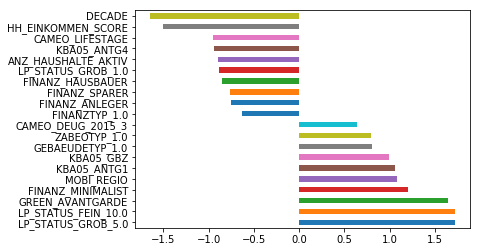

In [76]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Over-represented cluster:
#     3
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
    pca_reduced.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
    columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

plot_scaled_comparison(cleanedCustomer, kmeans, 3)


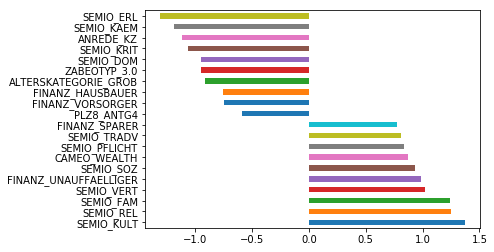

In [77]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Under-represented clusters:
#   6, 8, 2, 4
plot_scaled_comparison(cleanedCustomer, kmeans, 6)



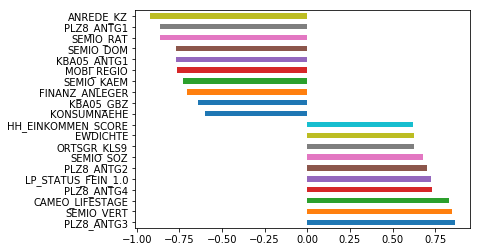

In [78]:
plot_scaled_comparison(cleanedCustomer, kmeans, 8)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)  

Customers are strongly over-represented in cluster 3 (32% more), which consists of the following characteristics:  

- Customers are high-earners (LPSTATUS_FEIN_10.0, LPSTATUS_GROB_5.0 with high scores, HH_EINKOMMEN_SCORE with low scores), and they ranked very low on the FINANZ_MINIMALIST category (which seems like a double negative, implying they are financially conscious).  They also tend to be members of the GREEN_AVANTGARDE  
- Customers tend to be older (lower DECADE)

Cusomters are under-reprsented in several clusters (6 - 10%;  8,2, and 4 - 7.5%+ ).  Cluster 6 is made up of the following types of individuals, which is a-typical of the customer base:

High Scores (meaning low affinity):
- FAM: family-minded
- REL: religious
- VERT: dreamful
- KULT: cultural-minded

Low Scores (meaning high affinity):
- ERL: event-oriented
- DOM: dominant-minded
- KAEM: combative attitude
- KRIT: critical-minded

So to generalize, people in cluster 6 tend to be more self-focused and combative, and less interested in the welfare of others.  This would seem to make sense in light of the results from cluster 2, which has a high number of green avantegard, which green would imply more concerned about the envirnoment and as an extension, concern for the welfare of the larger society.



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.